In [1]:
#pip install cvxpy
%pip install mglearn
%pip install cvxpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import pandas as pd
import cvxpy as cp
import mglearn
import seaborn as sns
from tabulate import tabulate

C:\Users\Knight_Oikos\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
#Columns
data = pd.read_csv("Main_Stats_3.csv")
data.columns

Index(['Rk', 'Player', 'Age', 'Team', 'Pos', 'G', 'MP', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'OWS', 'DWS', 'WS', 'WS/48',
       'BPM', 'VORP', 'PER', 'Salary'],
      dtype='object')

In [4]:
#Cleaned 
selected_cols = ["Player", "Team", "Pos", "G", "MP", "TRB", "AST", "STL", "BLK", "PTS", "WS","ORtg", "DRtg", "PER", "Salary"]
data_selected = data[selected_cols]
data_selected

,Player,Team,Pos,G,MP,TRB,AST,STL,BLK,PTS,WS,ORtg,DRtg,PER,Salary
0,A.J. Green,MIL,SG,35,9.9,1.3,0.6,0.2,0.0,4.4,0.8,121.0,115,11.5,20690909
1,A.J. Lawson,2TM,SG,15,7.2,1.4,0.1,0.1,0.0,3.7,0.1,112.0,118,13.9,1968175
2,Aaron Gordon,DEN,PF,68,30.2,6.6,3.0,0.8,0.8,16.3,6.8,124.0,115,19.5,3804360
3,Aaron Holiday,ATL,PG,63,13.4,1.2,1.4,0.6,0.2,3.9,0.9,110.0,117,9.4,1563518
4,Aaron Nesmith,IND,SF,73,24.9,3.8,1.3,0.8,0.5,10.1,2.0,111.0,119,10.5,877940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,Zach Collins,SAS,C,63,22.9,6.4,2.9,0.6,0.8,11.6,2.2,112.0,118,16.4,7350000
533,Zach LaVine,CHI,SG,77,35.9,4.5,4.2,0.9,0.2,24.8,7.1,116.0,115,19.0,37096500
534,Zeke Nnaji,DEN,PF,53,13.7,2.6,0.3,0.3,0.4,5.2,1.6,120.0,115,12.5,2617800
535,Ziaire Williams,MEM,SF,37,15.2,2.1,0.9,0.4,0.2,5.7,0.1,97.0,114,7.4,4591680


In [5]:
hist_sea = pd.read_csv("Historic_Season.csv")
hist_play = pd.read_csv("Historic_Playoff.csv")

hist_sea_avg = hist_sea.iloc[-1][["TRB","AST","STL","BLK","PTS"]]
hist_play_avg = hist_play.iloc[-1][["TRB","AST","STL","BLK","PTS"]]
hist_play_avg

TRB      45.13
AST     23.025
STL      7.965
BLK      5.495
PTS    108.005
Name: 21, dtype: object

In [6]:
#net rating calulation:(alpha * ORtg - beta * DRtg)
#col addition
def net_rating(data, alpha = 1, beta = 1):
    return (alpha * data["ORtg"] - beta * data["DRtg"]) 


In [7]:
#used for closest to league leader coeff
def closest_league_leader(data):
   #"Player", "Team", "Pos", "G", "MP", "TRB", "AST", "STL", "BLK", "PTS", "ORtg", "DRtg", "PER","WS","BPM", "VORP", "Salary"
    pts = data["PTS"]
    ast = data["AST"]
    reb = data["TRB"]

    ws = data["WS"]
    #league leaders 33.1ppg, 12.3 reb, 10.7 ast, 14.9 ws

    return (np.abs(pts - 33.1) + np.abs(ast - 10.7) + np.abs(reb - 12.3) + np.abs(ws - 14.9))

In [8]:
#usable data copy of main data
data_copy = data_selected.copy()
data_copy["Net_Rating"] = net_rating(data_selected)
data_copy = data_copy.dropna()
data_copy = data_copy[data_copy["G"] >= 58]
data_copy = data_copy[data_copy["MP"] >= 5]
print(data_copy.shape)
#data_copy = data_copy[data_copy["PTS"] >= 5]
Salary = data_copy["Salary"].values
print(data_copy.isna().sum())

(245, 16)
Player        0
Team          0
Pos           0
G             0
MP            0
TRB           0
AST           0
STL           0
BLK           0
PTS           0
WS            0
ORtg          0
DRtg          0
PER           0
Salary        0
Net_Rating    0
dtype: int64


In [9]:
def plot_roster(selected_indices, ylabel):
    selected_players = player_stats[selected_indices].sum(axis=0)
    selected_players = data_copy.iloc[selected_indices][["Player","G", ylabel, "Salary"]].copy()

    players = selected_players['Player']
    ratings = selected_players[ylabel]

    league_avg = data_copy[ylabel].mean()

    plt.figure(figsize=(10,6))
    plt.bar(players, ratings, color='skyblue')

    plt.axhline(y=league_avg, color='red', linestyle='--', label=f'League Average {ylabel}: {league_avg:.2f}')

    plt.title(f'{ylabel} of Selected Players')
    plt.xlabel('Player')
    plt.ylabel(ylabel)

    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

In [10]:
def print_comparison(selected_indices):
    selected_players = player_stats[selected_indices].sum(axis=0)

    # Calculate total team salary
    total_team_salary =  Salary[selected_indices].sum()

    #Season
    print("Team vs. Historic Season Stats")
    print(f"Total Team TRB: {selected_players[0]:.1f} (Target: {hist_sea_avg['TRB']:.1f})")
    print(f"Total Team AST: {selected_players[1]:.1f} (Target: {hist_sea_avg['AST']:.1f})")
    print(f"Total Team STL: {selected_players[2]:.1f} (Target: {hist_sea_avg['STL']:.1f})")
    print(f"Total Team BLK: {selected_players[3]:.1f} (Target: {hist_sea_avg['BLK']:.1f})")
    print(f"Total Team PTS: {selected_players[4]:.1f} (Target: {hist_sea_avg['PTS']:.1f})")
    print(f"Total Team Salary: ${total_team_salary:.2f} (Salary Cap: ${salary_cap:.2f})")
    
    print("Number of pleayers per position \n")
     
    num_C = int(np.sum(pos_mask_C[selected_indices]))
    num_PF = int(np.sum(pos_mask_PF[selected_indices]))
    num_SF = int(np.sum(pos_mask_SF[selected_indices]))
    num_SG = int(np.sum(pos_mask_SG[selected_indices]))
    num_PG = int(np.sum(pos_mask_PG[selected_indices]))

    # Print the number of players in each position
    print(f"Number of Centers (C): {num_C}")
    print(f"Number of Power Forwards (PF): {num_PF}")
    print(f"Number of Small Forwards (SF): {num_SF}")
    print(f"Number of Shooting Guards (SG): {num_SG}")
    print(f"Number of Point Guards (PG): {num_PG}")

    print("Selected Roster \n")

    selected_players_data = data_copy.iloc[selected_indices][["Player", "Pos","Team", "TRB","AST","STL","BLK","PTS", "ORtg", "DRtg", "Net_Rating", "Salary"]].copy()

    print("Selected Players:\n")
    total_O = 0
    total_D = 0
    for _, row in selected_players_data.iterrows():

        total_O += row["ORtg"]
        total_D += row["DRtg"]
        print(f"{row['Player']:20} POS: {row['Pos']} Team: {row['Team']} TRB: {row['TRB']:.2f} AST: {row['AST']:.2f} STL: {row['STL']:.2f} BLK: {row['BLK']:.2f} PTS: {row['PTS']:.2f} ORtg: {row['ORtg']:.2f} DRtg: {row['DRtg']:.2f}  Net Rating: {row['Net_Rating']:.2f} Salary: {row['Salary']:.2f} ")
    total_net = (total_O / 15) - (total_D/15)
    print(f"\nTotal Net Rating: {total_net:.2f}")

In [11]:
#Constraint formulation
num_players = (len(data_copy))
X = cp.Variable(num_players, boolean = True)
#constraints
#salary_cap = 123655000
salary_cap = 136021000 #2022/2023 Cap
#salary_cap = 140588000 #2024/2025 Cap
player_stats = data_copy[["TRB","AST","STL","BLK","PTS"]].values

const1 = cp.sum(X) <= 15
const2 = cp.sum(X) >= 14
const3 = cp.sum(Salary @ X) <= salary_cap

#Stat constraint season
const4 = cp.sum(player_stats[:, 0] @ X) >= hist_sea_avg["TRB"]
const5 = cp.sum(player_stats[:, 1] @ X) >= hist_sea_avg["AST"]
const6 = cp.sum(player_stats[:, 2] @ X) >= hist_sea_avg["STL"]
const7 = cp.sum(player_stats[:, 3] @ X) >= hist_sea_avg["BLK"]
const8 = cp.sum(player_stats[:, 4] @ X) >= hist_sea_avg["PTS"]

#position constraint
pos_mask_C = (data_copy["Pos"] == "C").astype(float).values
pos_mask_PF = (data_copy["Pos"] == "PF").astype(float).values
pos_mask_SF = (data_copy["Pos"] == "SF").astype(float).values
pos_mask_SG = (data_copy["Pos"] == "SG").astype(float).values
pos_mask_PG = (data_copy["Pos"] == "PG").astype(float).values

const9 = cp.sum(pos_mask_C @ X)>=2
const10 = cp.sum(pos_mask_PF @ X)>=2
const11 = cp.sum(pos_mask_SF @ X)>=2
const12 = cp.sum(pos_mask_SG @ X)>=2
const13 = cp.sum(pos_mask_PG @ X)>=2
const14 = cp.sum(pos_mask_C @ X)<=3
const15 = cp.sum(pos_mask_PF @ X)<=4
const16 = cp.sum(pos_mask_SF @ X)<=3
const17 = cp.sum(pos_mask_SG @ X)<=3
const18 = cp.sum(pos_mask_PG @ X)<=3

#optimization problem
constraints = [const1, const2, const3, const4, const5, const6, const7, const8,const9,const10, const11, const12, const13, const14, const15, const16, const17, const18]

Team vs. Historic Season Stats
Total Team TRB: 61.1 (Target: 45.6)
Total Team AST: 31.0 (Target: 25.3)
Total Team STL: 10.5 (Target: 8.5)
Total Team BLK: 7.1 (Target: 5.8)
Total Team PTS: 140.1 (Target: 110.8)
Total Team Salary: $135788321.00 (Salary Cap: $136021000.00)
Number of pleayers per position 

Number of Centers (C): 3
Number of Power Forwards (PF): 4
Number of Small Forwards (SF): 3
Number of Shooting Guards (SG): 3
Number of Point Guards (PG): 2
Selected Roster 

Selected Players:

Austin Reaves        POS: SG Team: LAL TRB: 3.00 AST: 3.40 STL: 0.50 BLK: 0.30 PTS: 13.00 ORtg: 129.00 DRtg: 117.00  Net Rating: 12.00 Salary: 1563518.00 
Chimezie Metu        POS: PF Team: SAC TRB: 3.00 AST: 0.60 STL: 0.30 BLK: 0.30 PTS: 4.90 ORtg: 124.00 DRtg: 113.00  Net Rating: 11.00 Salary: 1910860.00 
Chris Boucher        POS: PF Team: TOR TRB: 5.50 AST: 0.40 STL: 0.60 BLK: 0.80 PTS: 9.40 ORtg: 125.00 DRtg: 112.00  Net Rating: 13.00 Salary: 12690000.00 
Derrick Jones Jr.    POS: PF Team: CHI

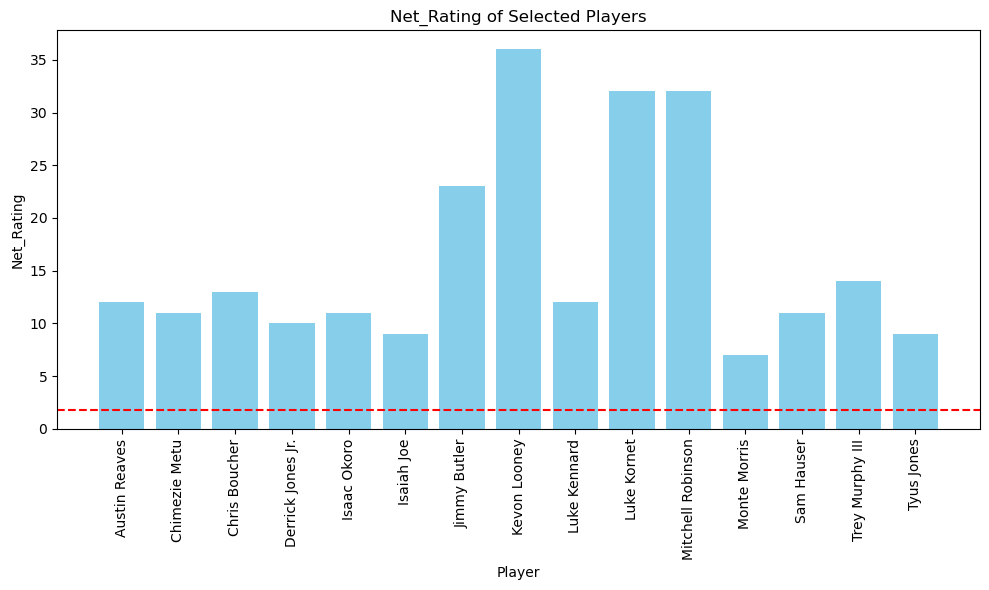

In [12]:
C_net = data_copy["Net_Rating"].values
obj_net = cp.Maximize(C_net @ X)

problem = cp.Problem(obj_net,constraints)

#solve problem
problem.solve()
selected_indices_net = np.where(X.value > 0.5)[0]
print_comparison(selected_indices_net)
plot_roster(selected_indices_net,"Net_Rating")

Team vs. Historic Season Stats
Total Team TRB: 91.5 (Target: 45.6)
Total Team AST: 65.7 (Target: 25.3)
Total Team STL: 12.8 (Target: 8.5)
Total Team BLK: 8.9 (Target: 5.8)
Total Team PTS: 305.8 (Target: 110.8)
Total Team Salary: $131165420.00 (Salary Cap: $136021000.00)
Number of pleayers per position 

Number of Centers (C): 3
Number of Power Forwards (PF): 4
Number of Small Forwards (SF): 2
Number of Shooting Guards (SG): 3
Number of Point Guards (PG): 3
Selected Roster 

Selected Players:

Aaron Gordon         POS: PF Team: DEN TRB: 6.60 AST: 3.00 STL: 0.80 BLK: 0.80 PTS: 16.30 ORtg: 124.00 DRtg: 115.00  Net Rating: 9.00 Salary: 3804360.00 
Chimezie Metu        POS: PF Team: SAC TRB: 3.00 AST: 0.60 STL: 0.30 BLK: 0.30 PTS: 4.90 ORtg: 124.00 DRtg: 113.00  Net Rating: 11.00 Salary: 1910860.00 
Damian Lillard       POS: PG Team: POR TRB: 4.80 AST: 7.30 STL: 0.90 BLK: 0.30 PTS: 32.20 ORtg: 126.00 DRtg: 121.00  Net Rating: 5.00 Salary: 2133278.00 
Darius Garland       POS: PG Team: CLE T

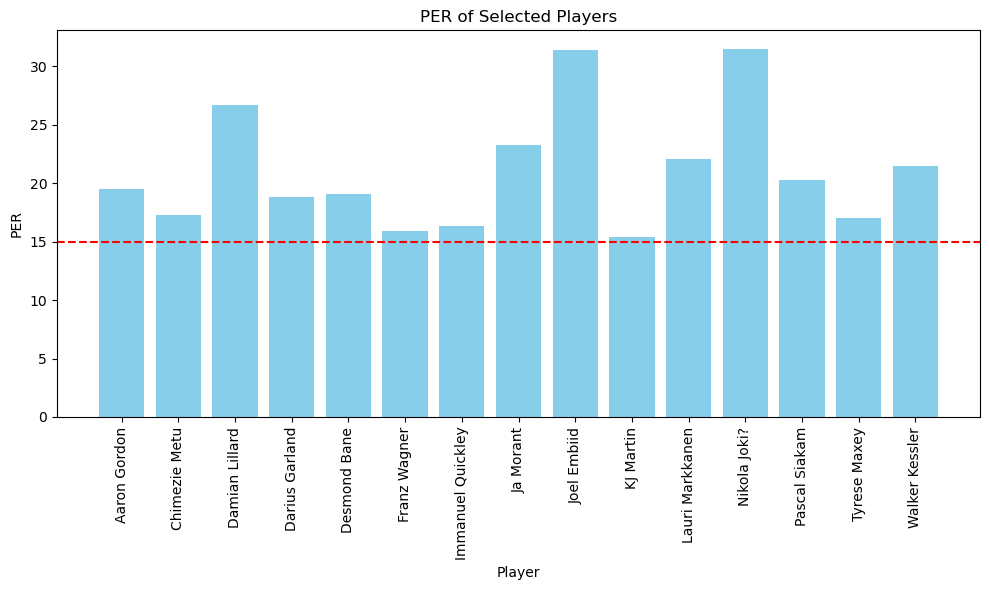

In [13]:
C_PER = data_copy["PER"].values
obj_PER = cp.Maximize(C_PER @ X)

#optimization problem

problem_PER = cp.Problem(obj_PER,constraints)

#solve problem
problem_PER.solve()
selected_indices_per = np.where(X.value > 0.5)[0]
print_comparison(selected_indices_per)
plot_roster(selected_indices_per,"PER")

Team vs. Historic Season Stats
Total Team TRB: 93.6 (Target: 45.6)
Total Team AST: 75.7 (Target: 25.3)
Total Team STL: 13.5 (Target: 8.5)
Total Team BLK: 6.5 (Target: 5.8)
Total Team PTS: 313.2 (Target: 110.8)
Total Team Salary: $135510713.00 (Salary Cap: $136021000.00)
Number of pleayers per position 

Number of Centers (C): 2
Number of Power Forwards (PF): 4
Number of Small Forwards (SF): 2
Number of Shooting Guards (SG): 3
Number of Point Guards (PG): 3
Selected Roster 

Selected Players:

Anthony Edwards      POS: SG Team: MIN TRB: 5.80 AST: 4.40 STL: 1.60 BLK: 0.70 PTS: 24.60 ORtg: 106.00 DRtg: 113.00  Net Rating: -7.00 Salary: 10733400.00 
Damian Lillard       POS: PG Team: POR TRB: 4.80 AST: 7.30 STL: 0.90 BLK: 0.30 PTS: 32.20 ORtg: 126.00 DRtg: 121.00  Net Rating: 5.00 Salary: 2133278.00 
Darius Garland       POS: PG Team: CLE TRB: 2.70 AST: 7.80 STL: 1.20 BLK: 0.10 PTS: 21.60 ORtg: 118.00 DRtg: 113.00  Net Rating: 5.00 Salary: 8920794.00 
Desmond Bane         POS: SG Team: MEM

,Player,closest_league_leaders
23,Anthony Edwards,32.4
88,Damian Lillard,17.7
97,Darius Garland,31.3
121,Desmond Bane,34.3
128,Domantas Sabonis,19.7
147,Evan Mobley,34.5
152,Franz Wagner,39.4
189,Ja Morant,24.8
268,Josh Giddey,36.3
292,Keldon Johnson,39.8


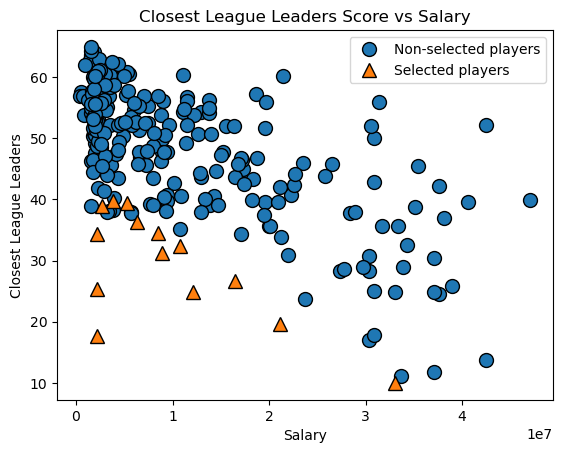

In [14]:
#the code to run with new coeff 

league_leaders = closest_league_leader(data_copy)
C_league_leaders = league_leaders.values

obj_league_leaders = cp.Minimize(C_league_leaders @ X)

#optimization problem

problem_league_leaders = cp.Problem(obj_league_leaders,constraints)

#solve problem
problem_league_leaders.solve()
selected_indices_league_leaders = np.where(X.value > 0.5)[0]
print_comparison(selected_indices_league_leaders)

selected_indices_closest_league_leader = np.where(X.value > 0.5)[0]

selected_players = data_copy.iloc[selected_indices_closest_league_leader]["Player"]
plot = data_copy.copy()
plot[["players_plot"]] = 0
plot["closest_league_leaders"] = league_leaders
table = plot[["Player", "closest_league_leaders"]]
table = table[table["Player"].isin(selected_players)]
plot.loc[plot["Player"].isin(selected_players), "players_plot"] = 1
mglearn.discrete_scatter(plot["Salary"], plot["closest_league_leaders"], plot["players_plot"])
plt.xlabel("Salary")
plt.ylabel("Closest League Leaders")
plt.title("Closest League Leaders Score vs Salary")
plt.legend(["Non-selected players", "Selected players"], fontsize=10);
table

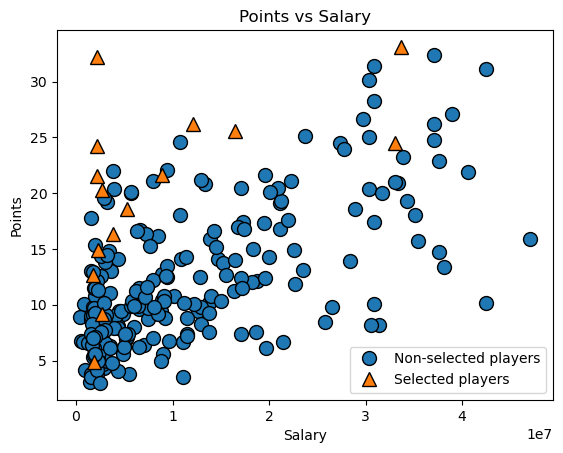

In [15]:
plot_dat = data_copy.copy()
plot_dat[["players_plot"]] = 0
selected_players = data_copy.iloc[selected_indices_per]["Player"]
plot_dat.loc[plot_dat["Player"].isin(selected_players), "players_plot"] = 1
mglearn.discrete_scatter(plot_dat["Salary"], plot_dat["PTS"], plot_dat["players_plot"])
plt.xlabel("Salary")
plt.ylabel("Points")
plt.title("Points vs Salary")
plt.legend(["Non-selected players", "Selected players"], fontsize=10);

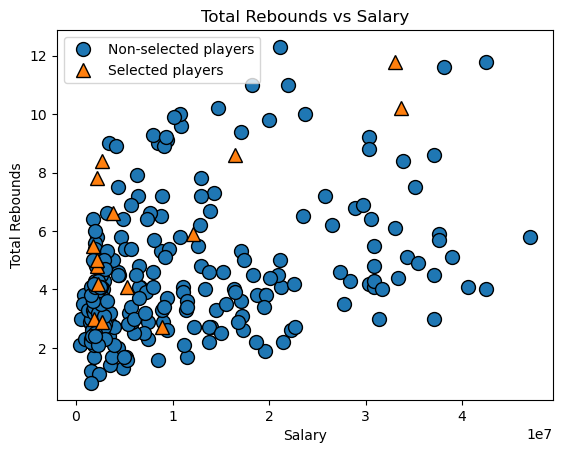

In [16]:
mglearn.discrete_scatter(plot_dat["Salary"], plot_dat["TRB"], plot_dat["players_plot"])
plt.xlabel("Salary")
plt.ylabel("Total Rebounds")
plt.title("Total Rebounds vs Salary")
plt.legend(["Non-selected players", "Selected players"], fontsize=10);

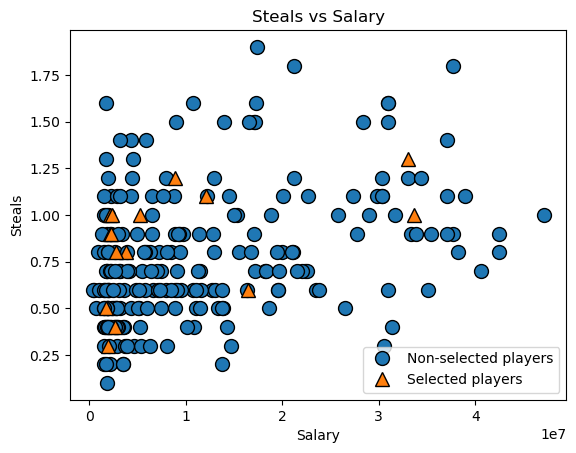

In [17]:
mglearn.discrete_scatter(plot_dat["Salary"], plot_dat["STL"], plot_dat["players_plot"])
plt.xlabel("Salary")
plt.ylabel("Steals")
plt.title("Steals vs Salary")
plt.legend(["Non-selected players", "Selected players"], fontsize=10);

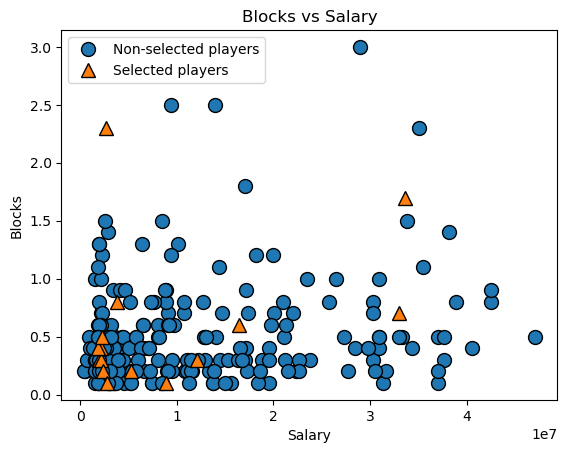

In [18]:
mglearn.discrete_scatter(plot_dat["Salary"], plot_dat["BLK"], plot_dat["players_plot"])
plt.xlabel("Salary")
plt.ylabel("Blocks")
plt.title("Blocks vs Salary")
plt.legend(["Non-selected players", "Selected players"], fontsize=10);

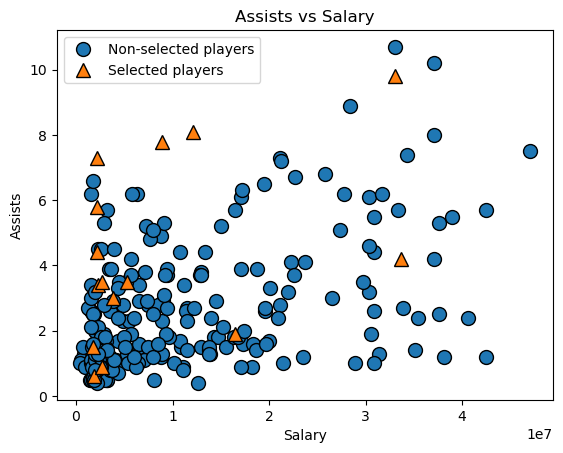

In [19]:
mglearn.discrete_scatter(plot_dat["Salary"], plot_dat["AST"], plot_dat["players_plot"])
plt.xlabel("Salary")
plt.ylabel("Assists")
plt.title("Assists vs Salary")
plt.legend(["Non-selected players", "Selected players"], fontsize=10);

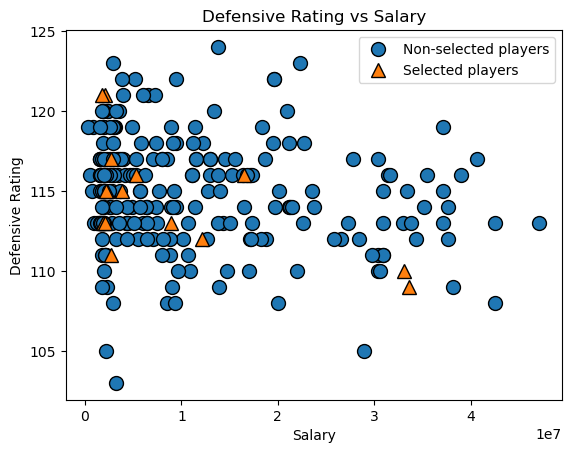

In [20]:
mglearn.discrete_scatter(plot_dat["Salary"], plot_dat["DRtg"], plot_dat["players_plot"])
plt.xlabel("Salary")
plt.ylabel("Defensive Rating")
plt.title("Defensive Rating vs Salary")
plt.legend(["Non-selected players", "Selected players"], fontsize=10);

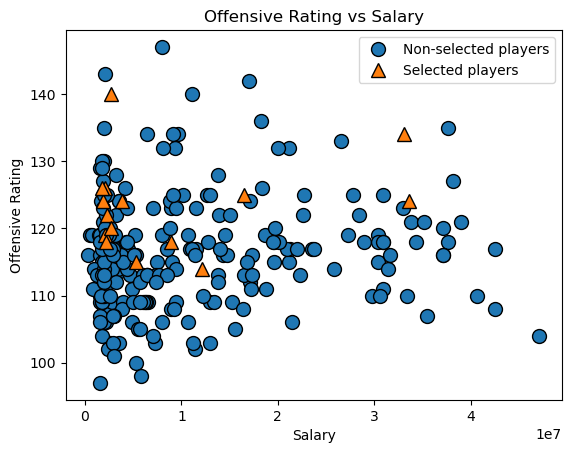

In [21]:
mglearn.discrete_scatter(plot_dat["Salary"], plot_dat["ORtg"], plot_dat["players_plot"])
plt.xlabel("Salary")
plt.ylabel("Offensive Rating")
plt.title("Offensive Rating vs Salary")
plt.legend(["Non-selected players", "Selected players"], fontsize=10);

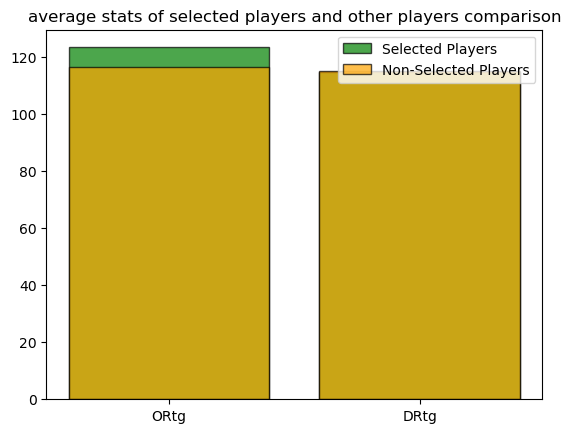

In [22]:
categories_rtg = ["ORtg", "DRtg"]
categories_stats = ["PTS","AST","TRB","BLK","STL"]
avgstats_selected = plot_dat.loc[plot_dat["Player"].isin(selected_players), ["ORtg", "DRtg"]].mean().tolist()
avgstats_nonselected = plot_dat.loc[~plot_dat["Player"].isin(selected_players), ["ORtg", "DRtg"]].mean().tolist()
plt.bar(categories_rtg, avgstats_selected, color='green', edgecolor='black', label='Selected Players', alpha=0.7)
plt.bar(categories_rtg, avgstats_nonselected, color='orange', edgecolor='black', label='Non-Selected Players', alpha=0.7)
plt.title("average stats of selected players and other players comparison")
plt.legend()
plt.show()

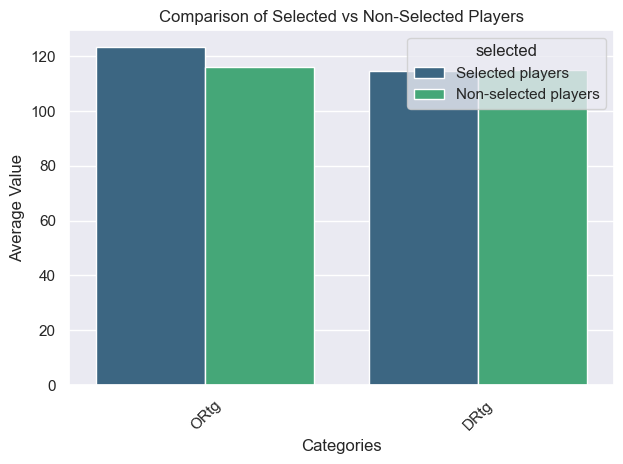

In [23]:
data = pd.DataFrame({"categories" : categories_rtg,
              "Selected players" : avgstats_selected,
              "Non-selected players" :avgstats_nonselected})
data_long = pd.melt(data, id_vars=["categories"], var_name="selected", value_name="average")   


sns.set_theme(style="darkgrid")

sns.barplot(x="categories", y="average", hue="selected", data=data_long, palette="viridis")
plt.title("Comparison of Selected vs Non-Selected Players")
plt.xlabel("Categories")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

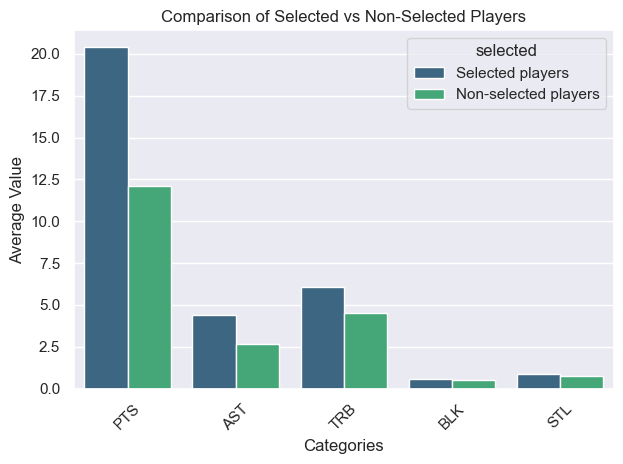

In [24]:
avgstats_selected = plot_dat.loc[plot_dat["Player"].isin(selected_players), ["PTS","AST","TRB","BLK","STL"]].mean().tolist()
avgstats_nonselected = plot_dat.loc[~plot_dat["Player"].isin(selected_players), ["PTS","AST","TRB","BLK","STL"]].mean().tolist()
data = pd.DataFrame({"categories" : categories_stats,
              "Selected players" : avgstats_selected,
              "Non-selected players" :avgstats_nonselected})
data_long = pd.melt(data, id_vars=["categories"], var_name="selected", value_name="average")   
sns.set_theme(style="darkgrid")

sns.barplot(x="categories", y="average", hue="selected", data=data_long, palette="viridis")
plt.title("Comparison of Selected vs Non-Selected Players")
plt.xlabel("Categories")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

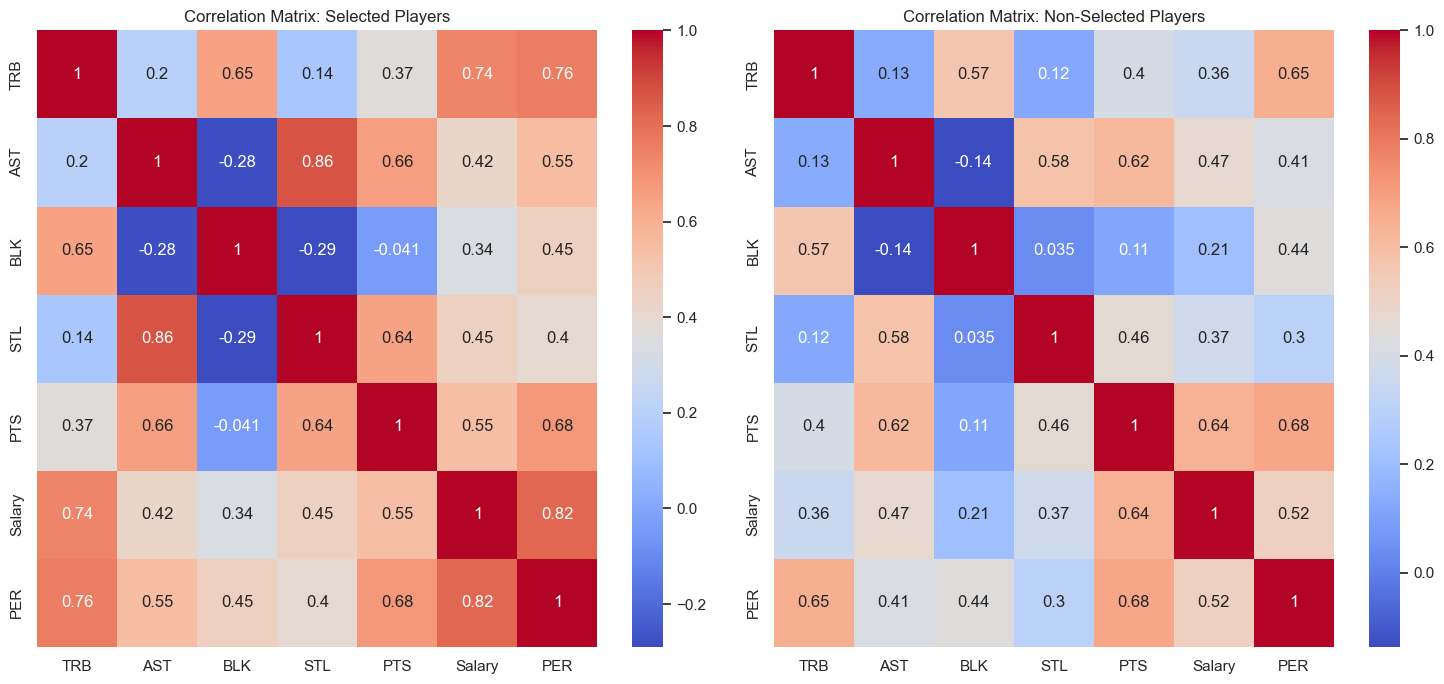

In [25]:
data_plot = data_copy.copy()
selected_players = data_plot.iloc[selected_indices_per].copy()
non_players = data_plot.drop(selected_players.index).copy()

player_stats = selected_players[['TRB', 'AST', 'BLK', 'STL', 'PTS', 'Salary', "PER"]].copy()
non_player_stats = non_players[['TRB', 'AST', 'BLK', 'STL', 'PTS', 'Salary', "PER"]].copy()

correlation_matrix = player_stats.corr()
non_correlation_matrix = non_player_stats.corr()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=ax1)
ax1.set_title("Correlation Matrix: Selected Players")

sns.heatmap(non_correlation_matrix, annot=True, cmap='coolwarm', ax=ax2)
ax2.set_title("Correlation Matrix: Non-Selected Players")

plt.tight_layout()
plt.show()